In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import funcs.CCE as CCE
from funcs.likelihood_funcs import * 
from funcs.utils import *
from funcs.kernel_param_funcs import *
import corner
import scipy
import pickle 

In [2]:
id = "0001"
DT = 0.5

sim_main = CCE.SXS_CCE(id, lev="Lev5", radius="R2")
new_times = np.arange(sim_main.times[0], sim_main.times[-1], DT)
sim_main = sim_interpolator(sim_main, new_times)

n_max = 6

t0 = 0
T = 50

qnm_list = [(2,2,n,1) for n in np.arange(0, n_max+1)]
spherical_modes = [(2, 2)]

chif_mag_0 = sim_main.chif_mag
Mf_0 = sim_main.Mf

In [3]:
with open('tuned_params.pkl', 'rb') as f:
    tuned_params = pickle.load(f)

tuned_params_lm = tuned_params[id]

In [4]:
ls_fit = qnmfits.multimode_ringdown_fit(
    sim_main.times,
    sim_main.h,
    modes=qnm_list,
    Mf=Mf_0,
    chif=chif_mag_0,
    t0=t0,
    T=T,
    spherical_modes=spherical_modes,
)

C_0 = ls_fit["C"]

true_params = []
for re_c, im_c in zip(np.real(ls_fit["C"]), np.imag(ls_fit["C"])):
    true_params.append(re_c)
    true_params.append(im_c)

In [5]:
with open('param_dict_sim_lm_full.pkl', 'rb') as f:
    param_dict_sim_lm = pickle.load(f)

with open('f_dict_sim_lm_full.pkl', 'rb') as f:
    f_dict_sim_lm = pickle.load(f)

tuning_hyperparams_s = [0.3996582031249995]  
#tuning_hyperparams = [1.2045142510058162, -0.010490761448761522, 3.5999456915185255, 0.4832915123677303]

hyperparam_rule_dict_s = {
    "sigma_max": "multiply",
}

tuned_param_dict_s = {mode: get_new_params(param_dict_sim_lm[id][mode], tuning_hyperparams_s, hyperparam_rule_dict_s) for mode in param_dict_sim_lm[id]}

In [14]:
fit_s = qnm_BGP_fit(sim_main.times, sim_main.h, qnm_list, Mf_0, chif_mag_0, t0, tuned_param_dict_s, kernel_s, T=T, spherical_modes=spherical_modes)
fit = qnm_BGP_fit(sim_main.times, sim_main.h, qnm_list, Mf_0, chif_mag_0, t0, tuned_params_lm, kernel_main, T=T, spherical_modes=spherical_modes)

/home/rvnd2/.local/lib/python3.11/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


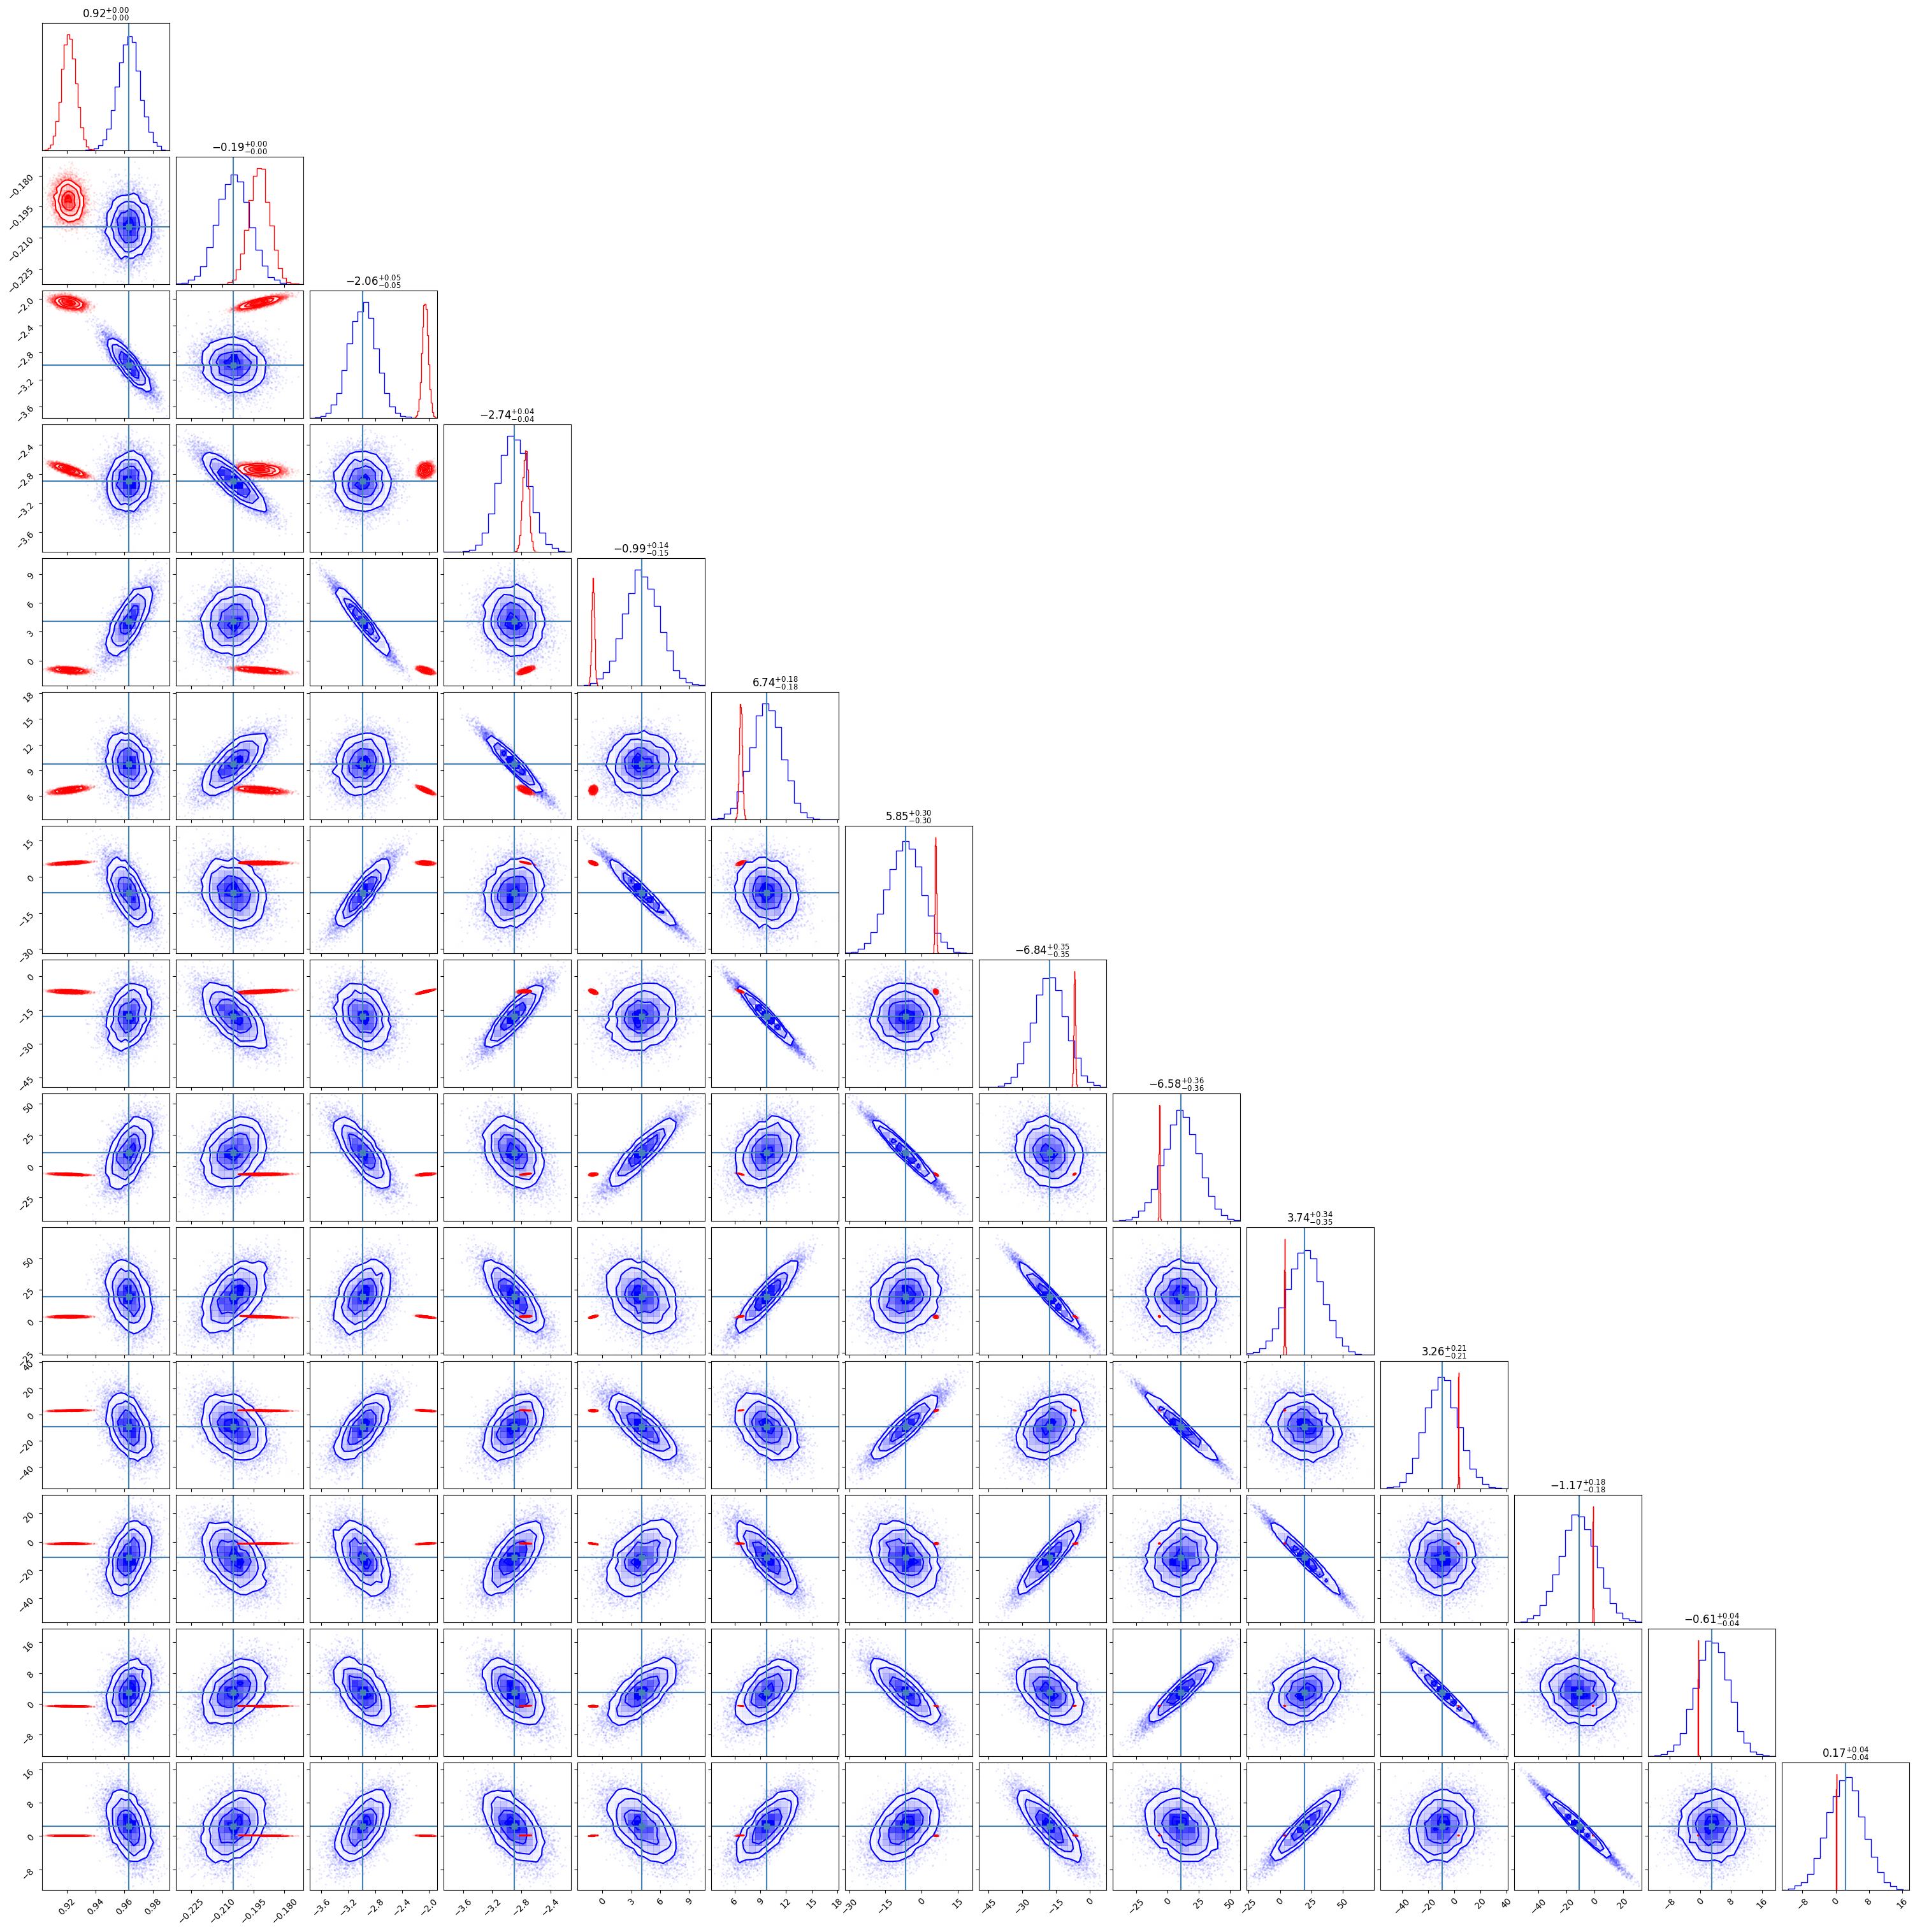

In [ ]:
samples_s = scipy.stats.multivariate_normal(fit_s["mean"], fit_s["covariance"], allow_singular=True).rvs(
    size=10000
)

samples = scipy.stats.multivariate_normal(fit["mean"], fit["covariance"], allow_singular=True).rvs(
    size=10000
)

figure = corner.corner(
    samples_s,
    truths = true_params,
    color='red',
    label_kwargs={"fontsize": 12},
    show_titles=True,
    title_kwargs={"fontsize": 12}
)

figure = corner.corner(
    samples,
    color='blue',
    fig=figure,
    label_kwargs={"fontsize": 12},
    show_titles=True,
    title_kwargs={"fontsize": 12}
) 

plt.show()